# Load package and data

In [1]:
import itertools
import matlab.engine
import plotly.express as px

import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load
import plotly.express as px

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(os.path.join(project_path,'src'))
from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import *
from zpyhelper.MVPA.preprocessors import scale_feature, average_odd_even_session,normalise_multivariate_noise, split_data, concat_data, extract_pc
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression, NeuralRDMStability

from multivariate.modelrdms import ModelRDM
from multivariate.rsa_runner import RSARunner
from scipy.spatial.distance import pdist, squareform

import sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS,TSNE 
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score,r2_score
from sklearn.preprocessing import OneHotEncoder

import scipy


In [2]:
from zpyhelper.MVPA.preprocessors import split_data
def compute_cross_rdm(X,groups,returnsym=True,neuralrdm_metric="correlation"):
    [X_odd,X_even] = split_data(X,groups)
    cross_rdm = scipy.spatial.distance.cdist(X_odd,X_even,neuralrdm_metric)
    sym_cross_rdm = (cross_rdm+cross_rdm.T)/2
    #np.fill_diagonal(sym_cross_rdm, np.nan)
    if returnsym:
        return sym_cross_rdm
    else:
        return cross_rdm
    
def compute_splitrun_rdm(X,groups,returnsym=True,neuralrdm_metric="correlation",returnave=True):
    [X_odd,X_even] = split_data(X,groups)
    odd_rdm = compute_rdm(X_odd,neuralrdm_metric)
    even_rdm = compute_rdm(X_even,neuralrdm_metric)
    cross_rdm = scipy.spatial.distance.cdist(X_odd,X_even,neuralrdm_metric)
    sym_cross_rdm = (cross_rdm+cross_rdm.T)/2
    if returnave:
        ave_within_rdm = (odd_rdm+even_rdm)/2 
        if returnsym:
            return sym_cross_rdm,ave_within_rdm
        else:
            return cross_rdm,ave_within_rdm
    else:
        if returnsym:
            return sym_cross_rdm,odd_rdm,even_rdm
        else:
            return cross_rdm,odd_rdm,even_rdm
def minmax_scale(rdm_unscaled,newmin=0,newmax=1):
    rdm_unscaledval = lower_tri(rdm_unscaled)[0]    
    minv,maxv = rdm_unscaledval.min(),rdm_unscaledval.max()
    #new range
    rdm_scaled_val = newmin + (newmax - newmin) * (rdm_unscaledval - minv) / (maxv - minv)
    scaledrdm = np.zeros_like(rdm_unscaled)
    scaledrdm[lower_tri(scaledrdm)[1]] = rdm_scaled_val
    scaledrdm = scaledrdm + scaledrdm.T
    return scaledrdm

In [3]:
project_path = r'E:\pirate_fmri\Analysis'
study_scripts   = os.path.join(project_path,'scripts','Exp1_fmri')
outputdata_dir  = os.path.join(project_path,'data','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers = pirate_defaults['participants']["generalizerids"]


In [4]:
# rois = [
#         "stimuligroup_FrontalMid2L",
#         "stimuligroup_FrontalSup2L",
#         "stimuligroup_ParietalInfL",
#         "stimuligroup_SMAL"
#         ] #+ \
rois =         [
        "sphere_neggtloc_FrontalMid2L",
        "sphere_posgtloc_CalcarineL",
        "sphere_posgtloc_CalcarineR",
        "sphere_posgtloc_HippocampusR",
        "sphere_posgtloc_PrecentralL"
        ]
ROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','mvnn_wbsearch_reg_compete_featurecartesian_combinexy_withsg_between')
roi_data=load(os.path.join(ROIRSAdir,"stimgroup_gtloc_roi_data.pkl"))

rois = rois = [#"cluster_posgtlocGnG_CuneusPrecuneusR",
        #"cluster_posgtlocGnG_OccipitalMidParietalSupL",
        #"sphere_posgtlocGnG_ParaHippocampalR",
        "cluster_posgtlocG_CalcarineLingualRL","cluster_posgtlocG_PostcentralParietalSupL",
        #"cluster_posfeatureG_OccipitalInfRL",
        "cluster_posfeatureG_ACCpreFrontalMedOrbL","cluster_posfeatureG_FrontalInfOperFrontalMid2L","cluster_posfeatureG_PostcentralR",
        "cluster_posfeaturenolocG_occipital"]
ROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','mvnn_wbsearch_reg_compete_featurecartesian_combinexy_testpairs_between')
roi_data = load(os.path.join(ROIRSAdir,"feature_gtloc_roi_data_4r.pkl"))

rois =  ["ofc_bilateral", "parietal_bilateral",  "hippocampus_bilateral","parahippocampus_bilateral"] + \
        ["rV1"]
#         ["rV1", "rV2", "rV3dva", "rV4v", "rV5", "rV6"]
ROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','anatomical')
roi_data = load(os.path.join(ROIRSAdir,"roi_data.pkl"))
gen_pval_annot = lambda p: np.array(["","*","**","***"])[[p>0.05,all([p<=0.05,p>0.01]),all([p<=0.01,p>0.001]),p<=0.001]][0]

# Geometry

## Dimensionality and RSA

In [5]:
#2 dimensions of hidden layer
def embedding_dimensions_PCA(X,ev_cutoff=0.95):
    X_reduced_ = PCA(n_components=ev_cutoff).fit_transform(X)
    return X_reduced_.shape[1]

def cal_geometry(X:np.ndarray,stimdf):   
    m  = ModelRDM(stimid      = stimdf["stim_id"].to_numpy(),
                  stimgtloc   = stimdf[["stim_x","stim_y"]].to_numpy(),
                  stimfeature = stimdf[["stim_shape","stim_color"]].to_numpy(),
                  stimgroup   = stimdf["stim_group"].to_numpy(),
                  sessions    = stimdf["stim_session"].to_numpy())
    if np.unique(stimdf["stim_session"]).size>1:
        regressormodelnames = [x for x in ["between_feature2d","between_gtlocEuclidean","between_stimuligroup"] if x in m.models.keys()]
    else:
        regressormodelnames = [x for x in ["feature2d","gtlocEuclidean","stimuligroup"] if x in m.models.keys()]
    keepmodels = [x for x in regressormodelnames  if np.unique(lower_tri(m.models[x])[0]).size>1]
    reg_estimator = MultipleRDMRegression(X, modelnames=keepmodels,
                                        modelrdms=[m.models[x] for x in keepmodels],
                                        rdm_metric="correlation",standardize=True)
    rdm_reg = pd.DataFrame(dict(zip(reg_estimator.modelnames,reg_estimator.fit().result)),index=[0])
    

    X_mean = np.mean(split_data(X,stimdf["stim_session"].to_numpy()),axis=0)
    pca = PCA().fit(X_mean)
    npcs_95 = np.argmax(pca.explained_variance_ratio_.cumsum()>=0.95)+1
    evar_first2pc = pca.explained_variance_ratio_.cumsum()[1]
    PR = np.power(pca.singular_values_.sum(),2)/np.power(pca.singular_values_,2).sum()
            
    return npcs_95,evar_first2pc,PR,rdm_reg, pca.explained_variance_ratio_

In [11]:
roi_embeddingdim_dfs, roi_rdmreg_dfs  = [],[]
PCA_EVs = {}
for roi in rois:
    PCA_EVs[roi] = {"train":[],"test":[],"all":[],"localizer":[]}
    for subdata,subid in zip(roi_data[roi],subid_list):
        print(f"{roi} - {subid}",end="\r",flush=True)
        subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"].copy()
        filters = {
            "train": np.all(np.vstack([
                        stimdf.taskname.to_numpy() == "navigation",
                        stimdf.stim_group.to_numpy() == 1 # train only
                    ]),axis=0),
            "test": np.all(np.vstack([
                        stimdf.taskname.to_numpy() == "navigation",
                        stimdf.stim_group.to_numpy() == 0 # test only
                    ]),axis=0),
            "all": stimdf.taskname.to_numpy() == "navigation",
            "localizer":stimdf.taskname.to_numpy() == "localizer"
        }

        for ds_name,dsf in filters.items():
            currdf = stimdf[dsf].copy().reset_index(drop=True)
            X = preprocedX[dsf,:]
            roi_dim,evar_first2pc,PR, rdm_reg, pcev = cal_geometry(X,currdf)
            PCA_EVs[roi][ds_name].append(pcev)
            roi_rdmreg_dfs.append(rdm_reg.assign(dataset=ds_name,roi=roi,subid=subid,subgroup=subgroup))
            roi_embeddingdim_dfs.append(
                pd.DataFrame(np.array([[roi_dim],[evar_first2pc],[PR]]).T,
                             columns=["embeddingdimensions","first2PCs_evar","participationratio"]).assign(dataset=ds_name,roi=roi,subid=subid,subgroup=subgroup)
                )

In [16]:
EVdflist = []
for roi in rois:
    for ds_name,ds in filters.items():
        tmpdf = pd.concat(
            [pd.DataFrame(np.vstack([x,x.cumsum(),np.arange(x.size)+1]).T,
                      columns=["ev","cumev","PC"]).assign(subid=subid,
                                                          subgroup="Generalizer" if subid in generalizers else "nonGeneralizer",
                                                          dataset=ds_name,roi=roi)  for x,subid in zip(PCA_EVs[roi][ds_name], subid_list)],
            axis=0
        ).reset_index(drop=True)
        EVdflist.append(tmpdf)
EVdf = pd.concat(EVdflist,axis=0).reset_index(drop=True)
EVdf["PC"] = [int(x) for x in EVdf["PC"]]

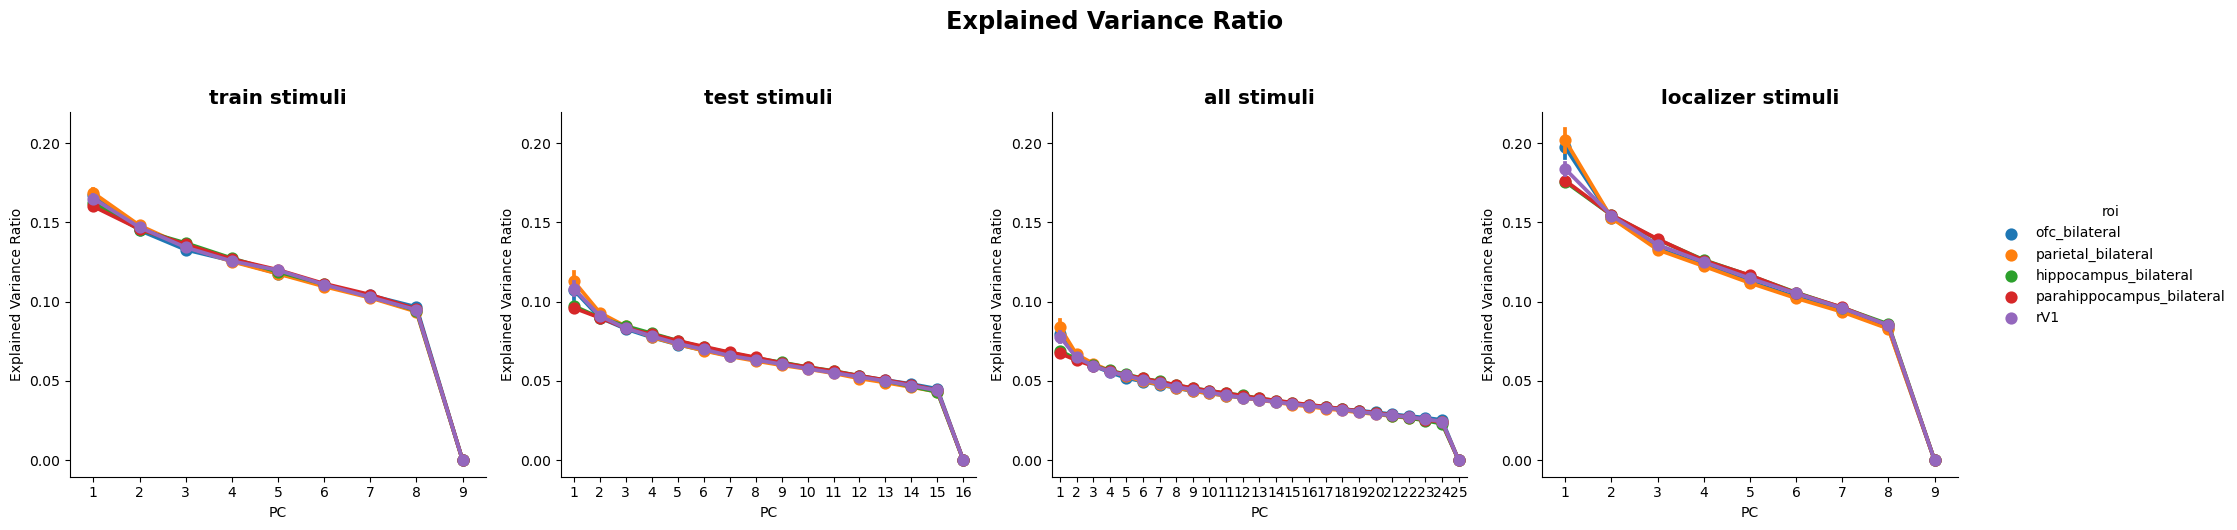

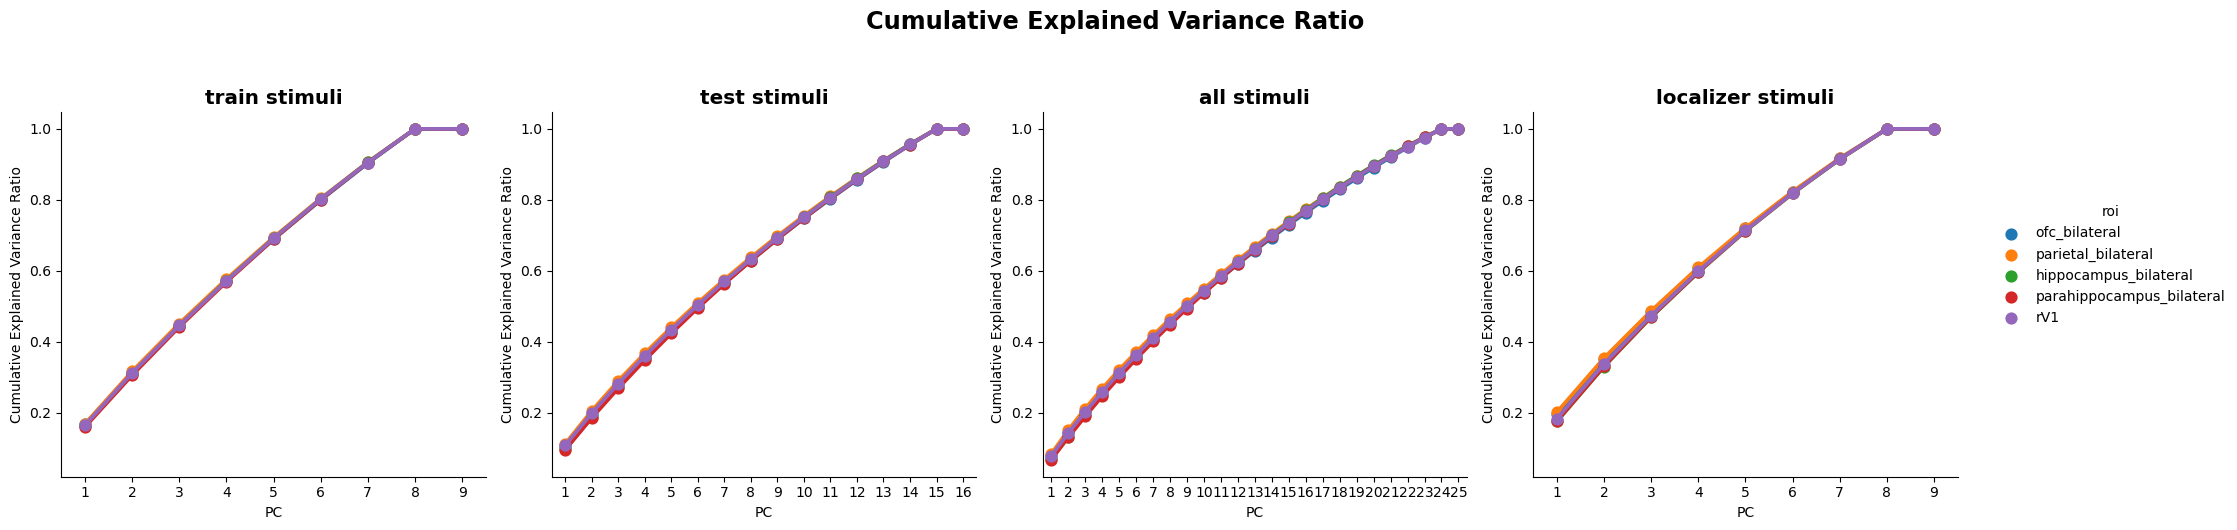

In [20]:
ytitle_dict = dict(zip(["ev","cumev"],
                       ["Explained Variance Ratio", "Cumulative Explained Variance Ratio"]
                     ))

for yvar in ytitle_dict.keys():    
    gs_cumEV = sns.catplot(EVdf,
                x="PC",y=yvar,
                row="dataset",
                col="subgroup",
                hue="roi",
                errorbar="se",
                kind="point",
                sharex=False)
    for ax in gs_cumEV.axes.flatten():
        ax.set_xlabel("PC",visible=True)
        ax.set_ylabel(ytitle_dict[yvar],visible=True)
        ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
    gs_cumEV.set_titles('{col_name}: {row_name} stimuli',fontweight="bold",size="x-large")
    gs_cumEV.figure.suptitle(ytitle_dict[yvar],fontweight="bold",size="xx-large",y=1.05)
    gs_cumEV.tight_layout()       
    

In [21]:
reg_df = pd.concat(roi_rdmreg_dfs,axis=0).reset_index(drop=True)
reg_df.head(5)

,between_feature2d,between_gtlocEuclidean,dataset,roi,subid,subgroup,between_stimuligroup,feature2d,gtlocEuclidean
0,-0.029312,-0.462366,train,ofc_bilateral,sub001,Generalizer,NaN,NaN,NaN
1,0.046619,-0.034375,test,ofc_bilateral,sub001,Generalizer,NaN,NaN,NaN
2,0.052386,-0.083142,all,ofc_bilateral,sub001,Generalizer,-0.00522,NaN,NaN
3,NaN,NaN,localizer,ofc_bilateral,sub001,Generalizer,NaN,-0.023244,-0.033257
4,0.160516,0.006651,train,ofc_bilateral,sub002,nonGeneralizer,NaN,NaN,NaN


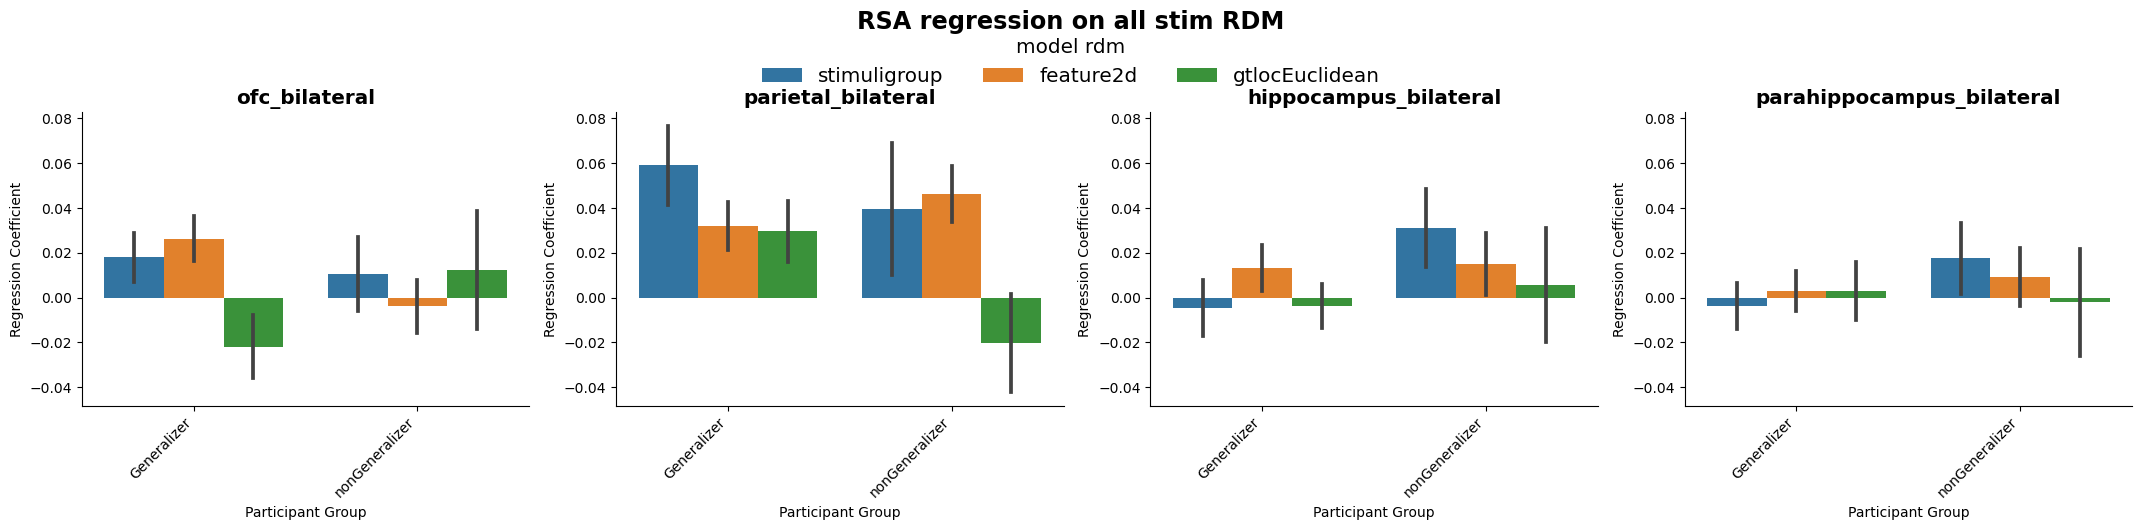

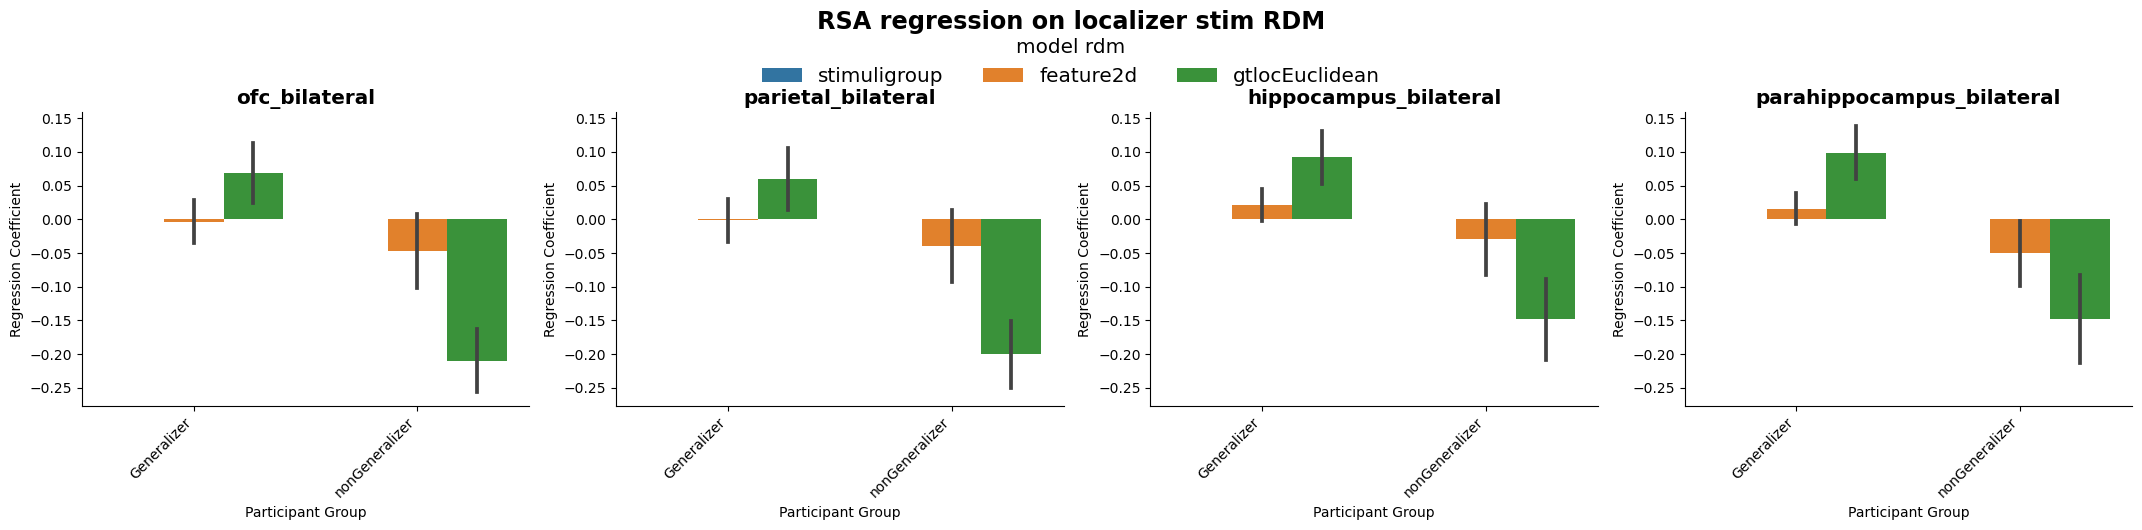

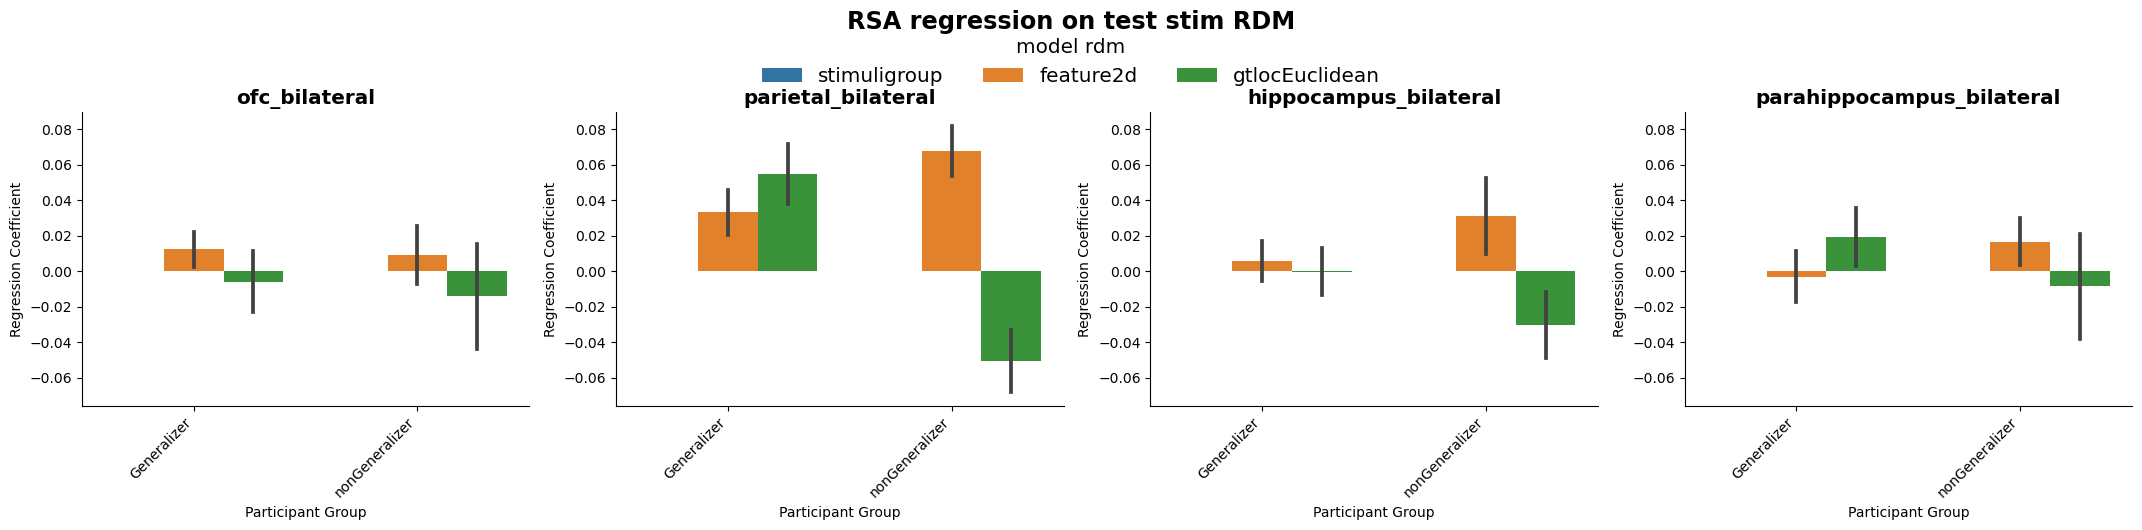

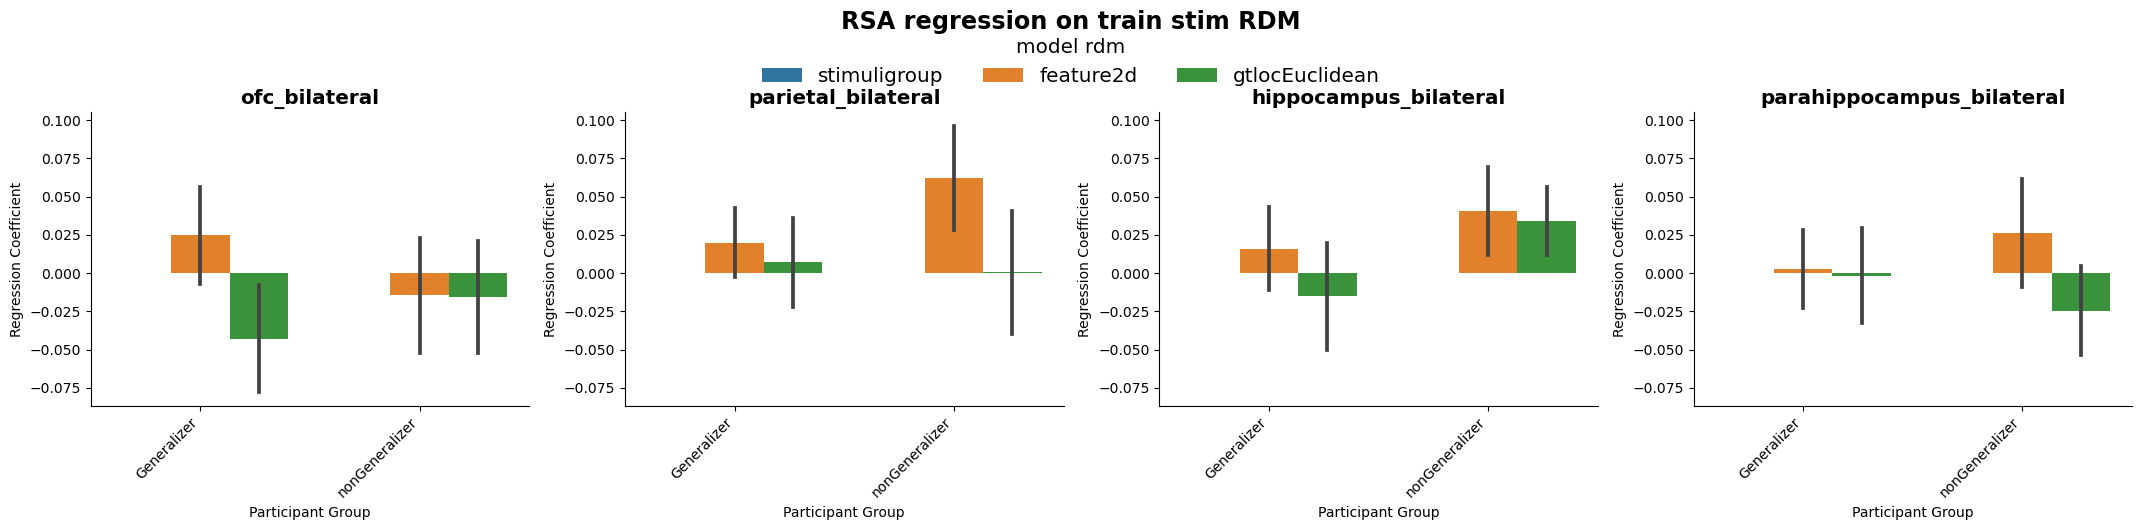

In [32]:

reg_df = pd.concat(roi_rdmreg_dfs,axis=0).reset_index(drop=True)
reg_df['feature2d'] = [bf if np.isnan(f) else f for f,bf in reg_df[["feature2d","between_feature2d"]].to_numpy()]
reg_df['gtlocEuclidean'] = [bf if np.isnan(f) else f for f,bf in reg_df[["gtlocEuclidean","between_gtlocEuclidean"]].to_numpy()]
reg_df['stimuligroup'] = reg_df['between_stimuligroup']

reg_df_long = pd.melt(reg_df,id_vars=["roi","subid","dataset","subgroup"],
                      value_vars=['stimuligroup', 'feature2d', 'gtlocEuclidean'],
                      value_name="regression coefficient",var_name="model rdm")
for ds in np.unique(reg_df_long.dataset):
    gs_rdmreg = sns.catplot(
        data=reg_df_long[(reg_df_long.dataset==ds)&(reg_df_long.roi!="rV1")],
        col="roi",y="regression coefficient",
        errorbar="se",
        x="subgroup",
        hue="model rdm",
        kind="bar")
    for ax in gs_rdmreg.axes.flatten():        
        ax.set_xlabel("Participant Group",visible=True)
        ax.set_ylabel("Regression Coefficient",visible=True)
        ax.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
        plt.setp(ax.get_xticklabels(),rotation=45,ha="right")

    sns.move_legend(gs_rdmreg,loc='upper center',ncol=10,bbox_to_anchor=[0.5,1.03],
                    fontsize="x-large",title_fontsize="x-large")
    gs_rdmreg.set_titles('{col_name}',fontweight="bold",size="x-large")
    gs_rdmreg.figure.suptitle(f"RSA regression on {ds} stim RDM",fontweight="bold",size="xx-large",y=1.05)
    gs_rdmreg.figure.tight_layout()
    